# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from sys import getsizeof
from datetime import datetime

# image processing libaries
import cv2
from scipy.misc import imread, imresize

# plotting libraries
import matplotlib.pyplot as plt
% matplotlib inline

# keras libraries
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout
from keras.applications import mobilenet

Using TensorFlow backend.


We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
base_path = 'Dataset/'
train_path = base_path + 'train'
val_path = base_path + 'val'

train_doc = np.random.permutation(open(os.path.join(base_path, 'train.csv')).readlines())
val_doc = np.random.permutation(open(os.path.join(base_path, 'val.csv')).readlines())

num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

In [4]:
# parameters 
num_classes = 5
batch_size = 40
total_frames = 30
sampled_frames = 30
img_height = 160
img_width = 160
num_epochs = 1

In [5]:
print(f'Training Sequences : {num_train_sequences}')
print(f'Validation Sequences : {num_val_sequences}')
print(f'Epochs : {num_epochs}')

Training Sequences : 663
Validation Sequences : 100
Epochs : 1


In [6]:
# utility function for plotting training results
def plot_training_stats(history):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    ax[0].plot(history.history['loss'])   
    ax[0].plot(history.history['val_loss'])
    ax[0].legend(['loss','val_loss'])

    ax[1].plot(history.history['categorical_accuracy'])   
    ax[1].plot(history.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
def generator(source_path, folder_list, batch_size, total_frames, sampled_frames, img_height, img_width, img_augmentation=False):
    
    print(f'Source dir: "{source_path}", Batch Size: {batch_size}')
    
    #create a list of image numbers you want to use for a particular video
    img_idx = np.round(np.linspace(0, total_frames-1, sampled_frames)).astype(int)
    
    def prepare_batch(batch, batch_size, img_idx, img_height, img_width, source_path, img_augmentation, len_seq):
        
        # x is the number of images you use for each video, (y,z) is the final size of the input images 
        # and 3 is the number of channels RGB
        batch_data = np.zeros((len_seq, len(img_idx), img_height, img_width,3))
        # batch_labels is the one hot representation of the output
        batch_labels = np.zeros((len_seq, 5))

        # iterate over the batch_size
        for folder in range(len_seq):

            # read all the images in the folder
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])

            #  Iterate iver the frames/images of a folder to read them in
            for idx,item in enumerate(img_idx): 

                image = imread(source_path+'/'+t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                if img_augmentation:
                    
#                     warped = cv2.warpAffine(
#                         image, np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
#                         (image.shape[1], image.shape[0])
#                     )

#                     gray = cv2.cvtColor(warped,cv2.COLOR_BGR2GRAY)
#                     x0, y0 = np.argwhere(gray > 0).min(axis=0)
#                     x1, y1 = np.argwhere(gray > 0).max(axis=0) 
#                     img_cropped = warped[x0:x1, y0:y1, :]
#                     img_resized = imresize(img_cropped,(img_height, img_width, 3))

                    img_resized = imresize(image,(img_height, img_width, 3))
                    
                    R_Mat = cv2.getRotationMatrix2D((img_width//2, img_height//2), np.random.randint(-7,7), 1.0)
                    img_resized = cv2.warpAffine(img_resized, R_Mat, (img_width, img_height))

                    batch_data[folder,idx,:,:,0] = (img_resized[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (img_resized[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (img_resized[:,:,2])/255

                else:
                    img_resized=imresize(image,(img_height, img_width, 3))

                    batch_data[folder,idx,:,:,0] = (img_resized[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (img_resized[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (img_resized[:,:,2])/255

            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

        return batch_data, batch_labels
    
    
    while True:
        t = np.random.permutation(folder_list)
        
        # calculate the number of batches
        num_batches = len(t)//batch_size
        
        # we iterate over the number of batches
        for batch in range(num_batches):
            
            batch_data, batch_labels = prepare_batch(
                batch, batch_size, img_idx, img_height, img_width, source_path, img_augmentation, len_seq=batch_size)
                        
            # yield the batch_data and the batch_labels, remember what does yield do
            yield batch_data, batch_labels

        # write the code for the remaining data points which are left after full batches
        rem_img = len(t) % batch_size
        
        if (rem_img != 0):
            batch_data, batch_labels = prepare_batch(
                batch, batch_size, img_idx, img_height, img_width, source_path, img_augmentation, len_seq=rem_img)
            
            yield batch_data, batch_labels 

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Conv3D + MaxPooling3D Model

In [8]:
#write your model here

def create_model(total_frames, sampled_frames, img_height, img_width, num_classes):
    
    model = Sequential()
    # conv3d layer
    model.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=(sampled_frames, img_height, img_width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    # conv3d layer
    model.add(Conv3D(32, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    # conv3d layer
    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # conv3d layer
    model.add(Conv3D(128, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    # Dense layer with drop out
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    # Dense layer with drop out
    model.add(Dense(64,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # Dense layer
    model.add(Dense(num_classes, activation='softmax'))
    
    #optimiser = 'sgd'
    optimiser = optimizers.Adam()
    
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [9]:
model = create_model(total_frames, sampled_frames, img_height, img_width, num_classes)

In [10]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_2 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 80, 80, 32)    128       
__________

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [11]:
def train_model(model, train_doc, val_doc, batch_size, num_epochs, img_augmentation):
    
    train_generator = generator(
        train_path, train_doc, batch_size, total_frames, sampled_frames, img_height, img_width, img_augmentation)

    val_generator = generator(
        val_path, val_doc, batch_size, total_frames, sampled_frames, img_height, img_width, img_augmentation)

    curr_dt_time = datetime.now()
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','_').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
    callbacks_list = [checkpoint, LR]
    
    num_train_sequences = len(train_doc)
    if (num_train_sequences % batch_size) == 0:
        steps_per_epoch = int(num_train_sequences / batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1
    
    num_val_sequences = len(val_doc)
    if (num_val_sequences % batch_size) == 0:
        validation_steps = int(num_val_sequences / batch_size)
    else:
        validation_steps = (num_val_sequences // batch_size) + 1

    history = model.fit_generator(
        train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, 
        validation_data=val_generator, validation_steps=validation_steps,
        verbose=1, callbacks=callbacks_list, class_weight=None, workers=1, initial_epoch=0
    )
    
    return history

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [12]:
# history = train_model(model, train_doc, val_doc, batch_size, num_epochs, img_augmentation)

#### We hit the Memory Overflow with image resolution 160x160 and 30 frames & batch size of 40

ResourceExhaustedError: OOM when allocating tensor with shape[40,16,30,160,160]

#### Let us try changing the hyperparameters to fit the model training requirements in available memory.

In [13]:
total_frames, sampled_frames, num_classes = 30, 16, 5
img_height, img_width = 160, 160
num_epochs, batch_size = 3, 30

In [14]:
model = create_model(total_frames, sampled_frames, img_height, img_width, num_classes)
history = train_model(model, train_doc, val_doc, batch_size, num_epochs, img_augmentation=False)

Epoch 1/3
Source dir: "Dataset/train", Batch Size: 30
Source dir: "Dataset/val", Batch Size: 30
23/23 [==============================] - 66s 3s/step - loss: 1.4661 - categorical_accuracy: 0.4353 - val_loss: 1.3824 - val_categorical_accuracy: 0.4700

Epoch 00001: saving model to model_init_2021-03-29_22_39_17.275907/model-00001-1.50890-0.41327-1.38240-0.47000.h5
Epoch 2/3
23/23 [==============================] - 52s 2s/step - loss: 0.9084 - categorical_accuracy: 0.6661 - val_loss: 0.6615 - val_categorical_accuracy: 0.7400

Epoch 00002: saving model to model_init_2021-03-29_22_39_17.275907/model-00002-0.93052-0.65309-0.66147-0.74000.h5
Epoch 3/3
23/23 [==============================] - 54s 2s/step - loss: 0.7272 - categorical_accuracy: 0.7146 - val_loss: 1.0572 - val_categorical_accuracy: 0.5900

Epoch 00003: saving model to model_init_2021-03-29_22_39_17.275907/model-00003-0.71732-0.71644-1.05717-0.59000.h5


##### We can see, clearly the model is training well. At just third epoch, we are getting the categorical accuracy of approx `77%`

### Let us experiment and find the right set of hyper-parameters that gives best performance for the model.

### Without No Data Augmentation

In [106]:
total_frames, sampled_frames, num_classes = 30, 20, 5
img_height, img_width = 160, 160
num_epochs, batch_size = 3, 30

model = create_model(total_frames, sampled_frames, img_height, img_width, num_classes)
history = train_model(model, train_doc, val_doc, batch_size, num_epochs, img_augmentation=False)

Epoch 1/3
Image dir =  Dataset/trainImage dir =  Dataset/val ; batch size = 30
 ; batch size = 30
23/23 [==============================] - 89s 4s/step - loss: 1.3498 - categorical_accuracy: 0.4843 - val_loss: 2.2461 - val_categorical_accuracy: 0.3400

Epoch 00001: saving model to model_init_2021-03-2917_36_11.425892/model-00001-1.36454-0.49020-2.24609-0.34000.h5
Epoch 2/3
23/23 [==============================] - 60s 3s/step - loss: 0.7316 - categorical_accuracy: 0.7059 - val_loss: 0.5854 - val_categorical_accuracy: 0.8400

Epoch 00002: saving model to model_init_2021-03-2917_36_11.425892/model-00002-0.74119-0.70739-0.58541-0.84000.h5
Epoch 3/3
23/23 [==============================] - 65s 3s/step - loss: 0.5511 - categorical_accuracy: 0.8040 - val_loss: 0.7586 - val_categorical_accuracy: 0.7300

Epoch 00003: saving model to model_init_2021-03-2917_36_11.425892/model-00003-0.55555-0.79638-0.75862-0.73000.h5


In [109]:
total_frames, sampled_frames, num_classes = 30, 20, 5
img_height, img_width = 100, 100
num_epochs, batch_size = 3, 30

model = create_model(total_frames, sampled_frames, img_height, img_width, num_classes)
history = train_model(model, train_doc, val_doc, batch_size, num_epochs, img_augmentation=False)

Epoch 1/3
Source dir: "Dataset/train", Batch Size =30
Source dir: "Dataset/val", Batch Size =30
23/23 [==============================] - 69s 3s/step - loss: 1.5880 - categorical_accuracy: 0.4379 - val_loss: 2.1296 - val_categorical_accuracy: 0.3900

Epoch 00001: saving model to model_init_2021-03-2917_41_55.417253/model-00001-1.53394-0.44193-2.12960-0.39000.h5
Epoch 2/3
23/23 [==============================] - 50s 2s/step - loss: 1.1199 - categorical_accuracy: 0.5752 - val_loss: 2.1950 - val_categorical_accuracy: 0.4000

Epoch 00002: saving model to model_init_2021-03-2917_41_55.417253/model-00002-1.11940-0.57164-2.19501-0.40000.h5
Epoch 3/3
23/23 [==============================] - 56s 2s/step - loss: 0.8074 - categorical_accuracy: 0.7009 - val_loss: 0.8413 - val_categorical_accuracy: 0.6100

Epoch 00003: saving model to model_init_2021-03-2917_41_55.417253/model-00003-0.82410-0.68929-0.84133-0.61000.h5


In [111]:
total_frames, sampled_frames, num_classes = 30, 20, 5
img_height, img_width = 120, 120
num_epochs, batch_size = 3, 30

model = create_model(total_frames, sampled_frames, img_height, img_width, num_classes)
history = train_model(model, train_doc, val_doc, batch_size, num_epochs, img_augmentation=False)

Epoch 1/3
Source dir: "Dataset/val", Batch Size: 30
Source dir: "Dataset/train", Batch Size: 30
23/23 [==============================] - 73s 3s/step - loss: 1.4782 - categorical_accuracy: 0.4402 - val_loss: 2.1523 - val_categorical_accuracy: 0.3500

Epoch 00001: saving model to model_init_2021-03-2917_49_19.016759/model-00001-1.48137-0.43137-2.15232-0.35000.h5
Epoch 2/3
23/23 [==============================] - 50s 2s/step - loss: 0.9952 - categorical_accuracy: 0.6150 - val_loss: 1.5110 - val_categorical_accuracy: 0.3900

Epoch 00002: saving model to model_init_2021-03-2917_49_19.016759/model-00002-0.95380-0.62594-1.51097-0.39000.h5
Epoch 3/3
23/23 [==============================] - 58s 3s/step - loss: 0.7403 - categorical_accuracy: 0.7320 - val_loss: 0.7473 - val_categorical_accuracy: 0.7000

Epoch 00003: saving model to model_init_2021-03-2917_49_19.016759/model-00003-0.70290-0.73454-0.74732-0.70000.h5


In [113]:
total_frames, sampled_frames, num_classes = 30, 20, 5
img_height, img_width = 240, 240
num_epochs, batch_size = 3, 20

model = create_model(total_frames, sampled_frames, img_height, img_width, num_classes)
history = train_model(model, train_doc, val_doc, batch_size, num_epochs, img_augmentation=False)

Epoch 1/3
Source dir: "Dataset/val", Batch Size: 20
Source dir: "Dataset/train", Batch Size: 20
34/34 [==============================] - 109s 3s/step - loss: 1.4806 - categorical_accuracy: 0.4503 - val_loss: 4.6200 - val_categorical_accuracy: 0.2900

Epoch 00001: saving model to model_init_2021-03-2917_54_43.595975/model-00001-1.50119-0.44495-4.61996-0.29000.h5
Epoch 2/3
34/34 [==============================] - 81s 2s/step - loss: 0.9742 - categorical_accuracy: 0.6159 - val_loss: 1.4131 - val_categorical_accuracy: 0.5900

Epoch 00002: saving model to model_init_2021-03-2917_54_43.595975/model-00002-0.98193-0.62293-1.41310-0.59000.h5
Epoch 3/3
34/34 [==============================] - 89s 3s/step - loss: 0.6954 - categorical_accuracy: 0.7322 - val_loss: 1.0016 - val_categorical_accuracy: 0.6300

Epoch 00003: saving model to model_init_2021-03-2917_54_43.595975/model-00003-0.67353-0.74208-1.00155-0.63000.h5


### With Data Augmentation

In [124]:
total_frames, sampled_frames, num_classes = 30, 18, 5
img_height, img_width = 160, 160
num_epochs, batch_size = 3, 30

model = create_model(total_frames, sampled_frames, img_height, img_width, num_classes)
history = train_model(model, train_doc, val_doc, batch_size, num_epochs, img_augmentation=True)

Epoch 1/3
Source dir: "Dataset/train", Batch Size: 30
Source dir: "Dataset/val", Batch Size: 30
23/23 [==============================] - 81s 4s/step - loss: 1.5592 - categorical_accuracy: 0.4059 - val_loss: 1.3310 - val_categorical_accuracy: 0.5200

Epoch 00001: saving model to model_init_2021-03-2919_17_07.651711/model-00001-1.57044-0.40875-1.33097-0.52000.h5
Epoch 2/3
23/23 [==============================] - 51s 2s/step - loss: 1.1367 - categorical_accuracy: 0.5650 - val_loss: 1.6261 - val_categorical_accuracy: 0.4700

Epoch 00002: saving model to model_init_2021-03-2919_17_07.651711/model-00002-1.11690-0.56109-1.62609-0.47000.h5
Epoch 3/3
23/23 [==============================] - 65s 3s/step - loss: 0.8210 - categorical_accuracy: 0.6826 - val_loss: 1.3448 - val_categorical_accuracy: 0.5100

Epoch 00003: saving model to model_init_2021-03-2919_17_07.651711/model-00003-0.81858-0.68326-1.34481-0.51000.h5


#### Running for 30 epochs

In [126]:
total_frames, sampled_frames, num_classes = 30, 18, 5
img_height, img_width = 160, 160
num_epochs, batch_size = 30, 30

model = create_model(total_frames, sampled_frames, img_height, img_width, num_classes)
print("Total Params:", model.count_params())
history = train_model(model, train_doc, val_doc, batch_size, num_epochs, img_augmentation=True)

Epoch 1/30
Source dir: "Dataset/val", Batch Size: 30
Source dir: "Dataset/train", Batch Size: 30
23/23 [==============================] - 78s 3s/step - loss: 1.4542 - categorical_accuracy: 0.4257 - val_loss: 2.3308 - val_categorical_accuracy: 0.2800

Epoch 00001: saving model to model_init_2021-03-2919_24_06.116069/model-00001-1.49042-0.41629-2.33084-0.28000.h5
Epoch 2/30
23/23 [==============================] - 48s 2s/step - loss: 1.0524 - categorical_accuracy: 0.6092 - val_loss: 1.1410 - val_categorical_accuracy: 0.5700

Epoch 00002: saving model to model_init_2021-03-2919_24_06.116069/model-00002-1.02138-0.61991-1.14102-0.57000.h5
Epoch 3/30
23/23 [==============================] - 65s 3s/step - loss: 0.8004 - categorical_accuracy: 0.6876 - val_loss: 1.0154 - val_categorical_accuracy: 0.5900

Epoch 00003: saving model to model_init_2021-03-2919_24_06.116069/model-00003-0.77999-0.70136-1.01539-0.59000.h5
Epoch 4/30
23/23 [==============================] - 65s 3s/step - loss: 0.7544 -


Epoch 00029: saving model to model_init_2021-03-2919_24_06.116069/model-00029-0.16273-0.95626-0.40522-0.87000.h5
Epoch 30/30
23/23 [==============================] - 64s 3s/step - loss: 0.1832 - categorical_accuracy: 0.9381 - val_loss: 0.3895 - val_categorical_accuracy: 0.8700

Epoch 00030: saving model to model_init_2021-03-2919_24_06.116069/model-00030-0.17270-0.94872-0.38948-0.87000.h5


In [152]:
print('Model size in mb: {}'.format('19.9'))

Model size in mb: 19.9


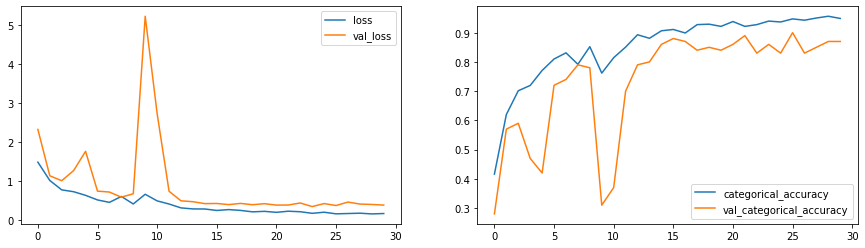

In [130]:
plot_training_stats(history)

## CNN LSTM with GRU

In [131]:
def create_model(total_frames, sampled_frames, img_height, img_width, num_classes, lstm_cells=64, 
                 dense_neurons=64, dropout=0.25):
    
    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'), 
                              input_shape=(sampled_frames, img_height, img_width, 3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))

    model.add(GRU(lstm_cells))
    model.add(Dropout(dropout))

    model.add(Dense(dense_neurons,activation='relu'))
    model.add(Dropout(dropout))

    model.add(Dense(num_classes, activation='softmax'))
    optimiser = optimizers.Adam(lr=0.0002)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model

In [135]:
total_frames, sampled_frames, num_classes = 30, 18, 5
img_height, img_width = 160, 160
num_epochs, batch_size = 30, 30

model = create_model(total_frames, sampled_frames, img_height, img_width, num_classes)
print("Total Params:", model.count_params())
history = train_model(model, train_doc, val_doc, batch_size, num_epochs, img_augmentation=True)

Total Params: 2572965
Epoch 1/30
Source dir: "Dataset/train", Batch Size: 30
Source dir: "Dataset/val", Batch Size: 30
23/23 [==============================] - 78s 3s/step - loss: 1.5677 - categorical_accuracy: 0.3203 - val_loss: 1.2142 - val_categorical_accuracy: 0.6000

Epoch 00001: saving model to model_init_2021-03-2920_05_49.459422/model-00001-1.56859-0.31976-1.21415-0.60000.h5
Epoch 2/30
23/23 [==============================] - 49s 2s/step - loss: 1.2583 - categorical_accuracy: 0.4683 - val_loss: 1.0698 - val_categorical_accuracy: 0.6200

Epoch 00002: saving model to model_init_2021-03-2920_05_49.459422/model-00002-1.25660-0.47360-1.06978-0.62000.h5
Epoch 3/30
23/23 [==============================] - 63s 3s/step - loss: 1.0524 - categorical_accuracy: 0.5859 - val_loss: 0.9696 - val_categorical_accuracy: 0.6200

Epoch 00003: saving model to model_init_2021-03-2920_05_49.459422/model-00003-1.05372-0.59578-0.96959-0.62000.h5
Epoch 4/30
23/23 [==============================] - 63s 3s


Epoch 00029: saving model to model_init_2021-03-2920_05_49.459422/model-00029-0.14989-0.98190-0.46280-0.84000.h5
Epoch 30/30
23/23 [==============================] - 63s 3s/step - loss: 0.1911 - categorical_accuracy: 0.9686 - val_loss: 0.5406 - val_categorical_accuracy: 0.8400

Epoch 00030: saving model to model_init_2021-03-2920_05_49.459422/model-00030-0.14569-0.98039-0.54063-0.84000.h5


In [ ]:
print('Model size in mb: {}'.format('29.5'))

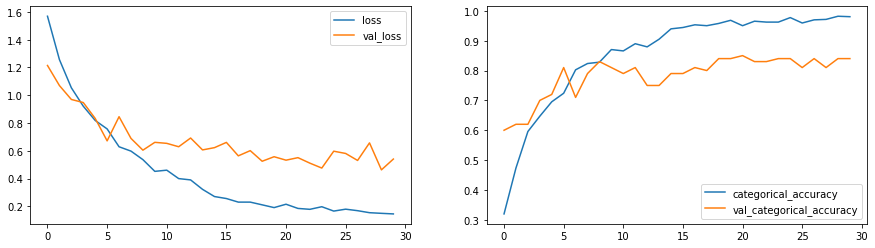

In [136]:
plot_training_stats(history)

## Transfer Learning

In [168]:
def create_model(total_frames, sampled_frames, img_height, img_width, num_classes, lstm_cells=64, 
                 dense_neurons=64, dropout=0.25, freeze_layers=True):
    
    mobilenet_layers = mobilenet.MobileNet(weights='imagenet', include_top=False)
    
    # using pre-downloaded imagenet weights - network connectivity limitation
    # mobilenet_layers = mobilenet.MobileNet(weights=None, include_top=False)
    # mobilenet_layers.load_weights('mobilenet_1_0_224_tf_no_top_imagenet_predownloaded.h5')
    
    model = Sequential()
    model.add(TimeDistributed(mobilenet_layers, input_shape = (sampled_frames, img_height, img_width, 3)))
    
    if freeze_layers:
        for layer in model.layers:
            layer.trainable = False

    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(lstm_cells))
    model.add(Dropout(dropout))

    model.add(Dense(dense_neurons,activation='relu'))
    model.add(Dropout(dropout))

    model.add(Dense(num_classes, activation='softmax'))

    optimiser = optimizers.Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model

In [149]:
total_frames, sampled_frames, num_classes = 30, 18, 5
img_height, img_width = 160, 160
num_epochs, batch_size = 30, 30

model = create_model(total_frames, sampled_frames, img_height, img_width, num_classes)
print("Total Params:", model.count_params())
history = train_model(model, train_doc, val_doc, batch_size, num_epochs, img_augmentation=True)

Total Params: 4302661
Epoch 1/30
Source dir: "Dataset/train", Batch Size: 30
Source dir: "Dataset/val", Batch Size: 30
23/23 [==============================] - 83s 4s/step - loss: 1.4394 - categorical_accuracy: 0.3885 - val_loss: 1.3058 - val_categorical_accuracy: 0.4200

Epoch 00001: saving model to model_init_2021-03-29_20_56_38.856594/model-00001-1.43372-0.39065-1.30582-0.42000.h5
Epoch 2/30
23/23 [==============================] - 49s 2s/step - loss: 1.0183 - categorical_accuracy: 0.6594 - val_loss: 0.9744 - val_categorical_accuracy: 0.6100

Epoch 00002: saving model to model_init_2021-03-29_20_56_38.856594/model-00002-1.01586-0.65913-0.97440-0.61000.h5
Epoch 3/30
23/23 [==============================] - 64s 3s/step - loss: 0.7230 - categorical_accuracy: 0.7886 - val_loss: 0.8491 - val_categorical_accuracy: 0.7200

Epoch 00003: saving model to model_init_2021-03-29_20_56_38.856594/model-00003-0.72605-0.79336-0.84910-0.72000.h5
Epoch 4/30
23/23 [==============================] - 62s

In [153]:
print('Model size in mb: {}'.format('24.7'))

Model size in mb: 24.7


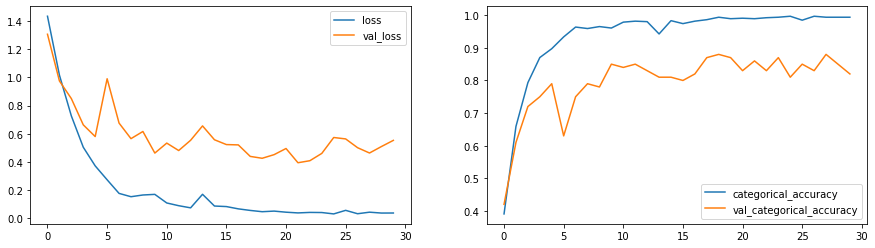

In [165]:
plot_training_stats(history)

#### We got the `Transfer Learning + LSTM Model` as the best performing model with validation accuracy of: `0.88` & validation loss: `0.46`

#### We'll recommend using this model, if the smart TV have 25.7 mb storage space available in it, since the model has best accuracy and in turn will give best user experience in terms of detection of gestures.

#### For lower spec TV, let's build a relatively lighter model by reducing the total parameters of our Conv3D model.

### Conv3D with Reduced Parameters - Memory Efficient Model

In [173]:
#write your model here

def create_model(total_frames, sampled_frames, img_height, img_width, num_classes):
    
    model = Sequential()
    # conv3d layer
    model.add(Conv3D(8, (3, 3, 3), padding='same', input_shape=(sampled_frames, img_height, img_width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    # conv3d layer
    model.add(Conv3D(16, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    # conv3d layer
    model.add(Conv3D(32, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # conv3d layer
    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    # Dense layer with drop out
    model.add(Flatten())
    model.add(Dense(64,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    # Dense layer with drop out
    model.add(Dense(64,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # Dense layer
    model.add(Dense(num_classes, activation='softmax'))
    
    #optimiser = 'sgd'
    optimiser = optimizers.Adam()
    
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model

In [175]:
total_frames, sampled_frames, num_classes = 30, 18, 5
img_height, img_width = 160, 160
num_epochs, batch_size = 30, 50

model = create_model(total_frames, sampled_frames, img_height, img_width, num_classes)
print("Total Params:", model.count_params())
history = train_model(model, train_doc, val_doc, batch_size, num_epochs, img_augmentation=True)

Total Params: 437413
Epoch 1/30
Source dir: "Dataset/val", Batch Size: 50
Source dir: "Dataset/train", Batch Size: 50
14/14 [==============================] - 94s 7s/step - loss: 1.7112 - categorical_accuracy: 0.3559 - val_loss: 2.2970 - val_categorical_accuracy: 0.3300

Epoch 00001: saving model to model_init_2021-03-29_21_54_08.612596/model-00001-1.74369-0.34238-2.29698-0.33000.h5
Epoch 2/30
14/14 [==============================] - 37s 3s/step - loss: 1.2454 - categorical_accuracy: 0.4959 - val_loss: 1.2916 - val_categorical_accuracy: 0.4900

Epoch 00002: saving model to model_init_2021-03-29_21_54_08.612596/model-00002-1.27540-0.48567-1.29158-0.49000.h5
Epoch 3/30
14/14 [==============================] - 63s 5s/step - loss: 1.0561 - categorical_accuracy: 0.5676 - val_loss: 0.9531 - val_categorical_accuracy: 0.6400

Epoch 00003: saving model to model_init_2021-03-29_21_54_08.612596/model-00003-1.06867-0.56109-0.95309-0.64000.h5
Epoch 4/30
14/14 [==============================] - 64s 

Model size in mb: 24.7


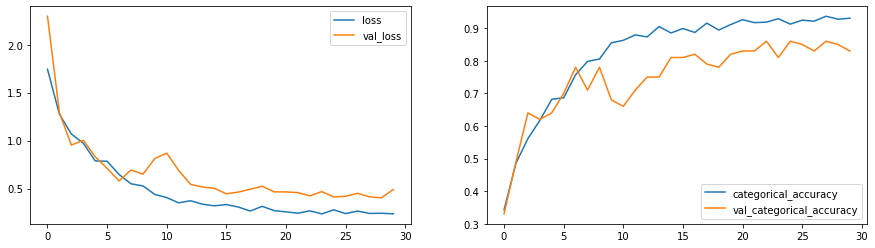

In [176]:
print('Model size in mb: {}'.format('24.7'))
plot_training_stats(history)

# Loading model and Testing

In [32]:
import time
from keras.models import load_model

In [33]:
# memory efficient model
model = load_model('model-00028-0.24013-0.93665-0.41316-0.86000.h5')

In [34]:
total_frames, sampled_frames, num_classes = 30, 18, 5
img_height, img_width = 160, 160
num_epochs, batch_size = 30, 50

In [35]:
val_generator = generator(
        val_path, val_doc, batch_size, total_frames, sampled_frames, img_height, img_width, img_augmentation=True)

In [36]:
batch_data, batch_labels=next(val_generator)

Source dir: "Dataset/val", Batch Size: 50


In [37]:
len(batch_labels)

50

In [38]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[0 2 2 3 4 3 2 2 3 0 2 0 1 3 1 3 2 0 1 0 1 2 2 2 0 4 1 3 0 1 2 4 2 1 3 2 1
 3 2 4 2 4 2 1 3 4 1 2 0 3]
